# VGG16 Transfer Learning for Colonoscopy Polyps

In the previous script ([3-Small_CNNs.ipynb](3-Small_CNNs.ipynb)), a classifier with over 95% of accuracy was obtained using only a small CNN (Conv-Conv-Conv-FC).

This script, I will try to apply Transfer Learning using pre-trained VGG16:
* Freeze the bottom part of the VGG16 - keeping the pre-trained weights in the convolutional layers.
* Save outputs from bottom moodel - because the bottom model is constant, it will be calculated only one time the outputs for the use of training and validation subsets.
* Train only the FC layer - The outputs of the bottom model will be the inputs for the trainable model.
* The best model will be saved on disk.

Let's import the needed libraries:

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras import applications
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers.normalization import BatchNormalization
import keras
from keras import optimizers
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow import set_random_seed
import time, os
from __future__ import with_statement
%matplotlib inline

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set calculation parameters such as image dimensions, folders for dataset, folder for saved models, number of training/validation images, training epochs and batch size.

**Important note**: `batch_size` is used in the next training / dataget lines and the intermediate bottom outputs will depend on this value!

In [2]:
# Dimensions of our images
img_width, img_height = 150, 150

# Train & validation folders
train_data_dir      = 'data_polyps/train'
validation_data_dir = 'data_polyps/validation'

# Folder to save the models
modelFolder = 'saved_models'

# Sample parameters
nb_train_samples      = 910 # number of training images (all classes)
nb_validation_samples = 302 # number of validation images (all classes)

# Initial training params from the previous small CNN script
epochs     = 50 # training epochs
batch_size = 64 # batch size for training

Define the paths & filenames for the outputs for training and validation using the bottom pre-trained VGG model. These outpus will be calculated only one time and use as inputs for the training of the FC layer (top model).

In [3]:
# Training results for our dataset using pre-trained VGG16 (Convolutional layers only, without top FC)
bottleneck_features_train_path = './saved_models/transferVGG16_bottleneck_features_train.npy'

# Validation results for our dataset using pre-trained VGG16 (Convolutional layers only, without top FC)
bottleneck_features_validation_path = './saved_models/transferVGG16_bottleneck_features_validation.npy'

# Top top model weights to used for future calculations for layer initialization
top_model_weights_path = './saved_models/transferVGG16_bottleneck_fc_model.h5'

# Earlystoping saved model
earlystoping_path = './saved_models/transferVGG16_earlystop_model.h5'

Correct the order of the channels if needed:

In [4]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Step 1 - Calculate the outputs of bottom VGG model for training and validation

You could observe that in `ImageDataGenerator` we do not use the data augmentation as in the previous script. So, we use only the original dataset of colonoscopy polyps/non-polyps.

In [5]:
def save_bottlebeck_features(batch_size):
    # Calculate the outputs for training and validations sets using bottom pre-trained VGG16
    # Input: batch_size - it will be used to save to file
    # Output: number of the examples for the saved outputs (it could be different from the original dataset!)
    
    # set numpy and tensorflow seeds for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed
    
    # No data augmentation!
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Build the VGG16 network - get VGG16 trained for imagenet without the top layer
    model = applications.VGG16(include_top=False, weights='imagenet')

    # Generate training data from train folder
    # generator = datagen.flow_from_directory(
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
  
    # Calculate the output of bottom VGG16 using training data
    bottleneck_features_train = model.predict_generator(
            generator, nb_train_samples // batch_size)
    # Save the traing outputs
    np.save(bottleneck_features_train_path, bottleneck_features_train)

    # Generate validation data from train folder
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
            
    # Calculate the output of bottom VGG16 using validation data
    bottleneck_features_validation = model.predict_generator(
            generator, nb_validation_samples // batch_size)
    
    # Save the validation outputs
    np.save(bottleneck_features_validation_path, bottleneck_features_validation)
    return (bottleneck_features_train.shape[0], bottleneck_features_validation.shape[0]) # return the new shapes if modified

Calculate the training and validation outputs from the bottom VGG16 model. Get the new values for the number of examples:

In [6]:
nb_train_samples, nb_validation_samples = save_bottlebeck_features(batch_size=64)

Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


**Observation**: The initial number of training / validation examples in the subsets (910 and 302) could be modified by the `nb_train_samples // batch_size` and `nb_train_samples // batch_size` when use ` model.predict_generator`! If this division will give a rest of 0, you will not have problems. 

For this reason, the saved output matrices from bottom VGG16 for training and validation will contain different number of examples. Thus, it is safer to use these new dimensions for the training.

In [7]:
print('New no of train samples      = ', nb_train_samples)
print('New no of validation samples = ', nb_validation_samples)

New no of train samples      =  896
New no of validation samples =  256


### Step 2 - Train the top FC model by using the outputs from the pre-trained bottom VGG16

The saved outputs for training and validation from the bottom VGG16 will be used as inputs for the FC layer (top model to train).

This is a function to plot the training and validation loss during the training:

In [8]:
class PlotLosses(keras.callbacks.Callback):
    # Show the live training and validation loss during the training
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="ACC_Train")
        plt.plot(self.x, self.val_acc, label="ACC_Val")
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0.)
        plt.grid()
        plt.show()

plot_losses = PlotLosses() # initialize the class

First, I will define a function to train the top model using different parameters such as number of epochs, batch size, optimizer type, drop rate and callback set:

In [9]:
def train_top_model(epochs, batch_size, optimizer, drop_rate, callbacks, summary):
    # Training top model
    # Input:
    # - epochs = no of training epochs
    # - batch_size = size of sample batch during training
    # - optimizer = string to define the optimizer (ex: 'adam', 'optimizers.RMSprop(lr=2e-4)')
    # - drop_rate = rate of dropped neurons
    # - callbacks = list of callbacks options
    # - summary = if True, show the model summary (True, False)
    
    # set numpy and tensorflow seeds for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed
    
    # Load training outputs from the pre-trained bottom VGG16
    train_data   = np.load(bottleneck_features_train_path)
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    # Load training outputs from the pre-trained bottom VGG16
    validation_data   = np.load(bottleneck_features_validation_path)
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    # Construct the top model using two parts: outputs from the bottom VGG16 + a FC layer
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the graph
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the model using the live plot of the loss
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose = 0,
              callbacks=callbacks)
    # Save the final model
    model.save_weights(top_model_weights_path)

    # Print model summary
    if summary == True:
        model.summary()
    
    # Evaluate final test loss and accuracy scores
    score_val = model.evaluate(validation_data, validation_labels, verbose=0)
    score_tr  = model.evaluate(train_data, train_labels, verbose=0)
    print('Train loss    :', score_tr[0])
    print('Train accuracy:', score_tr[1])
    print('Validation loss    :', score_val[0])
    print('Validation accuracy:', score_val[1])

Let's traing the FC model using `epochs = 50`, `batch_size = 64`, `optimizer = 'adam'` (the same as the previous script for small CNNs), original FC VGG16 layer topology, saving the last model and live plotting of loss:

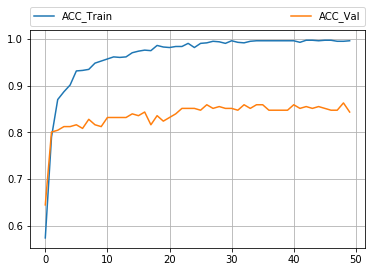

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Train loss    : 0.023065590844323327
Train accuracy: 0.9944196428571429
Validation loss    : 0.8642008661990985
Validation accuracy: 0.84375


In [10]:
epochs     = 50
batch_size = 64 # this value should be the same with the one used for save_bottlebeck_features()
optimizer  = 'adam'
drop_rate  = 0.5
callbacks  = [plot_losses]
summary    = True # for the first time show the summary of the trained top model

train_top_model(epochs, batch_size, optimizer, drop_rate, callbacks, summary)

The overfitting is huge. So, I tried to apply more regularization by increasing the drop rate to `0.9`:

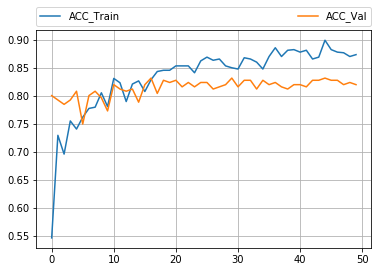

Train loss    : 0.11518474561827523
Train accuracy: 0.9575892857142857
Validation loss    : 0.46496586687862873
Validation accuracy: 0.8203125


In [11]:
epochs     = 50
batch_size = 64 # this value should be the same with the one used for save_bottlebeck_features()
optimizer  = 'adam'
drop_rate  = 0.9
callbacks  = callbacks=[plot_losses]
summary    = False # for the first time show the summary of the trained top model

nb_train_samples, nb_validation_samples = save_bottlebeck_features(batch_size)
train_top_model(epochs, batch_size, optimizer, drop_rate, callbacks, summary)

With increased drop rate, the overfitting is decreasing but results are not better than the previous small CNN.

## Conclusion

If we try to use VGG16 transfer learning for our current dataset, no better results will be obtained than a small CNN (over 90% test accuracy). This could be explained by the training of VGG16 with the Imagenet dataset that is very different with the polyps. In addition, we used the original dataset, without data augmentation because of the transfer learning advantage. 

Additional fine tunnings ([5-FineTuningVGG16.ipynb](5-FineTuningVGG16.ipynb)) should be used to search for better classifiers for the current task (prediction of a colonoscopy polyp image).

Have fun with DL! @muntisa

### Acknowledgements

I gratefully acknowledge the support of NVIDIA Corporation with the donation of the Titan Xp GPU used for this research ([https://developer.nvidia.com/academic_gpu_seeding](https://developer.nvidia.com/academic_gpu_seeding)).